# Analyse av diskriminering i COMPAS-algoritmen
## Prosjekt 1 i HON2200 - april 2021
### Theodor O. Aaberge, Silje Bentdal, Adrian Ommundsen og Gulla Torvund

Vi undersøker egenskapene til COMPAS-algoritmen ved å hente ut betingede sannsynligheter for estimatene og ved å utvikle en modell for algoritmens prediksjoner. Vi argumenterer for at algoritmen har er diskriminerende på bakgrunn av rase. 

## 1. Innledning

Et domene hvor det er blitt mulig å anvende maskinlæringsalgoritmer er i trekkingen av rettslige beslutninger. En spesifikk slik anvendelse er for å assistere i å gi risikoestimat for kriminelt tilbakefall, residivering, blant kriminelle. Slike anvendelser har vært i bruk, blant annet ble en slik algoritme, COMPAS-algoritmen, anvendt i Florida på 2010-tallet. I 2016 undersøkte det amerikanske tidsskriftet ProPublica en analyse av bruken av COMPAS-algoritmen, og fremmet anklage om at algoritmen hadde et diskriminerende bias.  

I denne rapporten gjennomfører vi en analyse av COMPAS-algoritmen liknende den utført av ProPublica-studien. Målet er å undersøke hvorvidt og i hvilken grad COMPAS-algoritmen diskriminerer på bakgrunn av rase. Planen for oppgaven er som følger. I seksjon [2](#2) (1a og 1b) gjør vi en enkel dataanalyse og sammenlikning av rater for faktisk residivering og predikert residivering innad i forskjellige grupper av befolkningen. I seksjon [3](#3) (1d) studerer vi beslutningene til COMPAS-algoritmen ved å trene en logistisk regresjonsmodell som predikerer COMPAS' avgjørelser på basis av, blant annet, rase og kjønn. Fra vår modell henter vi ut et mål, partial dependence, på hvor mye vekt COMPAS-algoritmen legger på rase-variabelen. I seksjon [4](#4) diskuterer vi probabilistike mål på grad av diskriminering. I seksjon [5](#5) diskuterer vi funnnene våre og argumenterer for at disse viser at COMPAS-algoritmen diskriminerer på basis av rase. Seksjon [6](#6) konkluderer. 


## 2.  Presentasjon og analyse av data
<a id='2'></a>

Dataen vi har med å gjøre, er den samme som ProPublica brukte i sin studie. Dataen er fra Broward County i Florida, som inneholder en stor mengde parametere (hele 53 stk!) om 7214 dømte forbrytere, blant dem informasjonen om de ble predikert av COMPAS å residivere og om de faktisk residiverte innen en to års periode.

For å forstå dataene, ønsker vi å undersøke spesifikke aspekter ved dem. Vi vil se på relativ frekvens av faktorer innad i de ulike gruppene og sammenligne resultatene. Tilfellene vi skal se på er 
* hvor ofte ulike grupperinger av mennesker (kvinner, menn, hvite og svarte) gjentar forbrytelser og blir predikert å begå straffbare handlinger i framtiden (som andel, ikke totalt antall).

* hvor ofte ulike grupper fikk ulike risikoskårer.

* hvor ofte de som begikk nye straffbare hadlinger (og de som ikke gjorde det) fikk ulike risikoskårer, og hvordan dette ser ut hvis du kun ser på hvite eller svarte.

Først importerer vi nødvendige pakker for hele rapporten. `pandas`brukes i stor grad ettersom vi behandler dataene som "DataFrames".

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import plot_partial_dependence

Vi leser inn dataen. Vi kvitter oss med den dataen hvor siktelsesdatoen er mer enn 30 dager unna datoen for arrestasjonen - ProPublica anså denne dataen som for usikker til å inkludere i studien.

In [2]:
data = pd.read_csv("..//Data/compas-scores-two-years.csv")
data = data[data["days_b_screening_arrest"] <= 30]
data = data[data["days_b_screening_arrest"] >= -30]

I denne "første" analysen lager vi en ny `pandas.DataFrame` og inkluderer den dataen som vi ønsker å se nærmere på. Som ProPublica, definerer vi at de som har fått COMPAS-score "Medium" eller "High" predikeres til å residivere innen to år.

In [3]:
df = pd.DataFrame({
    "kvinne": data.sex == "Female",
    "hvit": data.race == "Caucasian",
    "svart": data.race == "African-American",
    "tilbakefall": data.two_year_recid == 1,
    "predikert_tilbakefall": data.score_text != "Low",
    "lav_score": data.score_text == "Low",
    "medium_score": data.score_text == "Medium",
    "høy_score": data.score_text == "High",})

For å regne ut den relative frekvensen av forekomst av en spesifikk egenskap innad i en gruppe, brukes `prosentandel`. Funksjonen `barplott` tar inn de egenskapene og gruppene vi ønsker å undersøke og plotter resultatene i tabell og barplott.

In [4]:
def prosentandel(fokus, gruppe):
    """Regner ut prosentandelen av gruppen (gruppe) som har den spesifikke egenskapen (fokus)
    """
    return float(f'{len(df[fokus & gruppe]) / len(df[gruppe]) * 100:.1f}')

def barplott(fokusliste, gruppeliste, kol_navn, rad_navn, tittel, ha_tabell = 'Ja'):
    """Lager en DataFrame med ønskede prosentandeler og plotter den i et barplott.
    Tar inn lister over egenskaper og grupper man ønsker å undersøke, samt navn som blir synlig i tabell og plott
    OBS! I tabellen er alle tall prosentandeler
    """
    tabell = pd.DataFrame(columns=kol_navn)
    
    for i,fokus in enumerate(fokusliste):
        tabell.loc[i] = [prosentandel(fokus, gruppe) for gruppe in gruppeliste]
    tabell.index = rad_navn
    ax = tabell.plot.bar(colormap='Set3', figsize=(8,6), rot=0)
    ax.set_ylabel('Prosentandel')
    ax.set_title(tittel)
    plt.rcParams.update({'font.size': 13})
    if ha_tabell == 'Ja': # default er å vise tabellen i tillegg til barplottet
        display(tabell)         

Med disse funksjonene kan vi se på den relative forekomsten av egenskaper innad i gruppene og sammenlikne dem:

<a id='21a'></a>
### Hvor ofte gjentar ulike grupperinger av mennesker (kvinner, menn, hvite og svarte) forbrytelser og blir predikert å begå straffbare handlinger i framtiden?

,Kvinner,Menn,Hvite,Svarte
Tilbakefallende,35.1,47.9,39.1,52.3
Predikert tilbakefallende,40.5,45.5,33.1,57.6


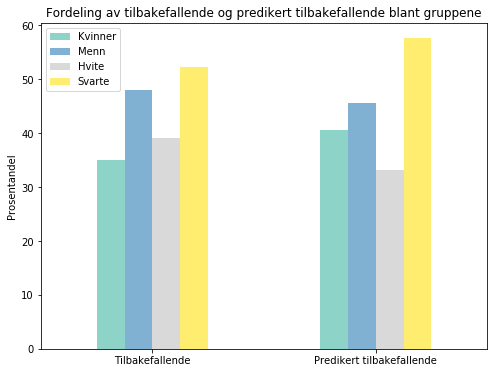

In [5]:
resid_predresid = [df.tilbakefall, df.predikert_tilbakefall]
gruppe = [df.kvinne, ~df.kvinne, df.hvit, df.svart]
gruppenavn = ['Kvinner', 'Menn', 'Hvite', 'Svarte']
resid_predresid_navn = ['Tilbakefallende', 'Predikert tilbakefallende']
tittel1 = 'Fordeling av tilbakefallende og predikert tilbakefallende blant gruppene'
barplott(resid_predresid, gruppe, gruppenavn, resid_predresid_navn, tittel1)

Vi ser at COMPAS-algoritmen predikerer en større andel svarte og kvinner til å residivere enn dét som faktisk er tilfelle, mens den vipper i motsatt retning for menn og hvite. Vi ser også at de ulike gruppene har forskjellige residiveringsrater.

<a id='21b'></a>
### Hvor ofte fikk de ulike gruppene de tre risikoskårene lav, middels og høy?


,Kvinner,Menn,Hvite,Svarte
Lav score,59.5,54.5,66.9,42.4
Middels score,27.7,25.7,22.5,31.0
Høy score,12.9,19.9,10.6,26.6


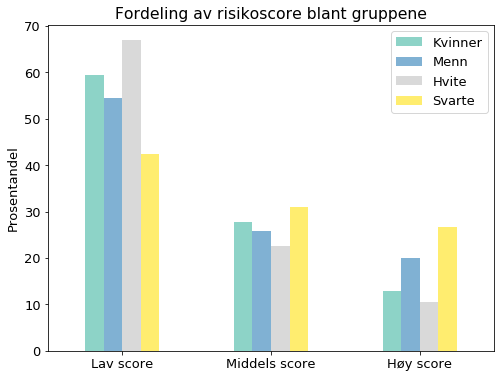

In [6]:
score = [df.lav_score, df.medium_score, df.høy_score]
score_navn = ['Lav score', 'Middels score', 'Høy score']
tittel2 = 'Fordeling av risikoscore blant gruppene'

barplott(score, gruppe, gruppenavn, score_navn, tittel2)

Det mest fremtredende resultatet her er at hvite har tydelig lavere score enn svarte. Hvite har en overveiende prosentandel med lav score, mens de svartes score er mer jevt fordelt.

<a id='21c'></a>
### Hvor ofte fikk tilbakefallende og ikke-tilbakefallende ulike risikoskårer, og hvordan ser dette ut når vi kun ser på hvite og svarte?

,Tilbakefallende,Ikke-tilbakefallende
Lav score,38.3,69.7
Middels score,31.5,21.4
Høy score,30.2,8.8


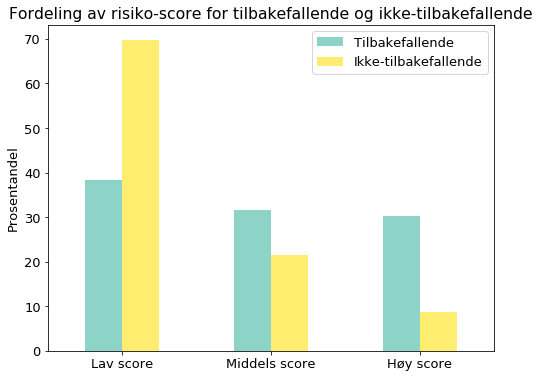

In [7]:
resid = [df.tilbakefall, ~df.tilbakefall]
resid_navn = ['Tilbakefallende', 'Ikke-tilbakefallende']
tittel3 = 'Fordeling av risiko-score for tilbakefallende og ikke-tilbakefallende'

barplott(score, resid, resid_navn, score_navn, tittel3)

Totalt sett er COMPAS-algoritmen bedre på å predikere de som ikke tilbakefaller enn de som tilbakefaller. Det bør poengteres at dersom man, som ProPublica og vi gjør, definerer både middels og høy score til å gi positiv prediktiv verdi, gjør ikke algoritmen det så dårlig som det tilsynelatende kan se ut som her. Legger man scorene sammen, ser vi at COMPAS predikerer ikke-tilbakefallende korrekt 70% av gangene og tilbakefallende 62% av gangene.

<a id='21d'></a>

,Tilbakefallende hvite,Tilbakefallende svarte,Ikke-tilbakefallende hvite,Ikke-tilbakefallende svarte
Lav score,49.6,28.5,78.0,57.7
Middels score,30.7,33.4,17.3,28.4
Høy score,19.7,38.2,4.8,13.9


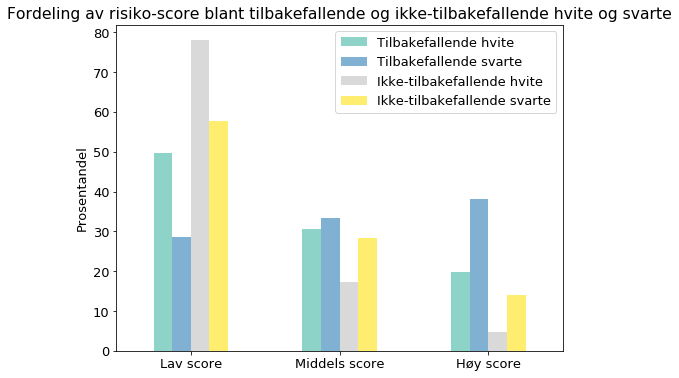

In [8]:
etnisk_resid = [df.hvit & df.tilbakefall, df.svart & df.tilbakefall, df.hvit & ~df.tilbakefall, df.svart & ~df.tilbakefall]
etnisk_resid_navn = ["Tilbakefallende hvite", "Tilbakefallende svarte","Ikke-tilbakefallende hvite","Ikke-tilbakefallende svarte"]
tittel4 = 'Fordeling av risiko-score blant tilbakefallende og ikke-tilbakefallende hvite og svarte'

barplott(score, etnisk_resid, etnisk_resid_navn, score_navn, tittel4)

COMPAS-scoren gjenspeiler ikke-tilbakefallende hvite godt (78%) og ikke-tilbakefallende svarte nogenlunde (58%). For tilbakefallende hvite predikerer den omtrent like godt som en random-algoritme, ettersom halvparten får lav score. For tilbakefallende gjør algoritmen det langt bedre for svarte (72%).

### Rater og betinget sannsynlighet for undergrupper
<a id='22a'></a>

Vi ønsker nå å se på data for følgende grupper:
* Hele befolkningen
* Kvinner 
* Menn 
* Hvite
* Svarte

Vi undersøker raten av falske positive, sanne positive, falske negative og sanne negative. I tillegg ønsker vi å se på sannsynligheten for at gruppen residiverer (tilbakefall) gitt at de er blitt predikert til å gjøre det, altså COMPAS-algoritmens positiv prediktive verdi.   
Til dette bruker vi funksjonene `falsk_positiv`, `sann_positiv`, `falsk_negativ`, `sann_negativ` og `p_residiv_g_høy`. 

In [9]:
def falsk_positiv(gruppe):
    """Regner ut raten av falske positive for en gitt gruppe
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: raten av falske positive i prosent med én desimal. 
    """
    # FP / (FP + SN)
    return float(f'{len(df[gruppe & df.predikert_tilbakefall & ~df.tilbakefall]) / len(df[gruppe & ~df.tilbakefall]) * 100:.1f}')

def sann_positiv(gruppe):
    """Regner ut raten av sanne positive for en gitt gruppe
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: raten av sanne positive i prosent med én desimal.
    """
    # SP / (SP + FN)
    # sensitivitet
    return float(f'{len(df[gruppe & df.predikert_tilbakefall & df.tilbakefall]) / len(df[gruppe & df.tilbakefall]) * 100:.1f}')

def falsk_negativ(gruppe):
    """Regner ut raten av falske negative for en gitt gruppe
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: raten av falske negative i prosent med én desimal.
    """
    # FN / (FN + SP)
    return float(f'{len(df[gruppe & ~df.predikert_tilbakefall & df.tilbakefall]) / len(df[gruppe & df.tilbakefall]) * 100:.1f}')

def sann_negativ(gruppe):
    """Regner ut raten av sanne negative for en gitt gruppe
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: raten av sanne negative i prosent med én desimal.
    """
    # SN / (SN + FP)
    # spesifisitet
    return float(f'{len(df[gruppe & ~df.predikert_tilbakefall & ~df.tilbakefall]) / len(df[gruppe & ~df.tilbakefall]) * 100:.1f}')

def p_residiv_g_høy(gruppe):
    """Regner ut sannsynligheten for at en gruppe residiverer gitt at de har blitt predikert til å gjøre det
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: sannsynlighet i prosent med én desimal.
    """
    return float(f'{len(df[gruppe & df.predikert_tilbakefall & df.tilbakefall]) / len(df[gruppe & df.predikert_tilbakefall]) * 100:.1f}')

In [10]:
alle = np.full(len(df), True)

In [11]:
functions = [falsk_positiv, falsk_negativ, sann_positiv, sann_negativ, p_residiv_g_høy]
grouplist = [alle, df.kvinne, ~df.kvinne, df.hvit, df.svart]
namelist = ['Alle', 'Kvinner', 'Menn', 'Hvite', 'Svarte']
d = {}
for name, group in zip(namelist, grouplist):
    inner_dict = {}
    for function in functions:
        inner_dict[function.__name__] = function(group)
    d[name] = inner_dict
d

{'Alle': {'falsk_positiv': 30.3,
  'falsk_negativ': 38.3,
  'sann_positiv': 61.7,
  'sann_negativ': 69.7,
  'p_residiv_g_høy': 63.0},
 'Kvinner': {'falsk_positiv': 30.2,
  'falsk_negativ': 40.4,
  'sann_positiv': 59.6,
  'sann_negativ': 69.8,
  'p_residiv_g_høy': 51.7},
 'Menn': {'falsk_positiv': 30.3,
  'falsk_negativ': 37.9,
  'sann_positiv': 62.1,
  'sann_negativ': 69.7,
  'p_residiv_g_høy': 65.4},
 'Hvite': {'falsk_positiv': 22.0,
  'falsk_negativ': 49.6,
  'sann_positiv': 50.4,
  'sann_negativ': 78.0,
  'p_residiv_g_høy': 59.5},
 'Svarte': {'falsk_positiv': 42.3,
  'falsk_negativ': 28.5,
  'sann_positiv': 71.5,
  'sann_negativ': 57.7,
  'p_residiv_g_høy': 65.0}}

Spesifisiteten (sanne negative) sier oss noe om hvor bra COMPAS klarer å identifisere personer som ikke kommer til å få tilbakefall. Sensitiviteten (sanne positive) sier noe om hvor bra COMPAS klarer å identifisere personer som kommer til å residivere. Det er først når begge disse tallene er høye det kan konkluderes med at algoritmen er god. Dersom det ene tallet er relativt høyt, imens det andre er relativt lavt, så sier dette noe om algoritmen er strengere i den ene eller andre retningen. For eksempel har vi for hvite at COMPAS har høy sann negativ rate og lav sann positiv rate. Ut ifra dette kan vi trekke frem en hypotese om at den generelt gir lav score for hvite.

Falske positive er personer som ikke residiverer, men som COMPAS predikerer at vil gjøre det. Dette vil være mennesker som får strengere straff enn fortjent. Raten av falske positive vil være viktig å holde lav for individualistiske samfunn.   
Falske negative er personer vi kanskje slipper ut i samfunnet igjen, men som likevel begår en kriminell handling. Disse menneskene vil utgjøre en fare for samfunnet. Raten av falske negative vil være viktig å holde lav for kollektivistiske samfunn. 

Positiv prediktiv verdi sier noe om hvor sannsynlig det er at gruppen residiverer gitt at de blir predikert til å gjøre det. Denne er relativt lav, men høyere enn 50%, for alle grupper. Man ønsker gjerne at dette tallet skal være så høyt som mulig. Dette vil det indikere på at man innfører de riktige tiltakene. På denne måten unngår man å bruke unødvendige ressurser på personer som kan slippes ut i samfunnet igjen.

## 3.   Modellering av skjevheter i COMPAS-algoritmen
<a id='3'></a>

Vi undersøker så skjevheter i COMPAS på bakgrunn av rase ved å kontrollere for kjønn, alder, kriminell historie og eventuell gjentatt forbrytelse. Her gjør vi hovedsaklig det samme som ProPublica-studien: vi trener en algoritme på en del av dataen vi har, bruker denne modellen til å predikere den resterende testdataen og sjekker egenskapene til modellen. Vi trener altså modellen vår til å predikere COMPAS-prediksjonen av tilbakefall. Vi bruker `sklearn`-biblioteket og dens `LogisticRegression` for å trene modellen vår. Grunnen til at vi bruker logistisk regresjon er at denne metoden fungerer godt på klassifikasjon med binært utfall.

In [12]:
# velger hensiktsmessig data (samma som ProPublica)
X = data[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]

# lager dummies (0 eller 1) av featuresene som er strings
categorical_cols = ["age_cat", "race", "sex", "c_charge_degree"]
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')

# tar bort overflødige dummies
X = X.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male", "c_charge_degree_F"], axis=1)

# 'fasiten' vår er COMPAS sin prediksjon av tilbakefall (score = (Medium or High))
Y = data["score_text"] != "Low"

# splitter treningsdata og testdata med sklearn sin 'train_test_split', standard test size
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

In [13]:
# lager modellen vår, som er sklearn sin 'LogisticRegression'
model = LogisticRegression(random_state=0, max_iter=10000)

# trener modellen (tilpasser vekter) og bias på treningsdataen
model.fit(X_train, Y_train)

# tester modellen på testdataen og ser hvor godt modellen gjøre det
Y_mdl = model.predict(X_test)
print(f'Nøyaktigheten til modellen er {accuracy_score(Y_mdl, Y_test):.3f}.')

Nøyaktigheten til modellen er 0.741.


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Skjevheter på bakgrunn av etnisitet <a id='3a'></a>

Nå sjekker vi hvor mye vekt som legges på etnisitet når vi korrigerer for andre features. For å finne dette, skaper vi en "standard" person hvor ingen features vektlegges, og kun biasen sendes inn i sigmoid-funksjonen (aktiveringsfunksjonen i logistisk regresjon). Denne standardpersonen er, som spesifisert i oppgaven, en hvit mann mellom 25-45 år og med charge degree F, altså det vi tok bort fra X tidligere. Deretter sammenlikner vi denne nøytrale personen mot en person som kun har egenskapen 'race_African-American = True'. Dette betyr at dersom vi har to helt like personer (med disse egenskapene) der etnisitet er det eneste som skiller seg ut, kan vi se hvordan rasen påvirker scoren. 

In [14]:
# trenger en sigmoid-funksjon for å skape en "nøytral" person (se neste celle)
def sigmoid(z):
    """klassisk sigmoid-funksjon som tar inn et tall z og returnerer (1/(1+e^-z)) = (e^z/(1+e^z))
    """
    return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z))) #np.where tar høyde for overflow

In [15]:
# lager en nøytral person ved å kun sende biasen inn i sigmoidfunksjonen 
kontroll = sigmoid(model.intercept_)
vekter = model.coef_[0]
# vekter[4] er vekten til race_African-American 
er_svart = vekter[4]
# finner racialBias, bias mht rase, i modellen vår
racialBias = np.exp(er_svart) / (1 - kontroll  + (kontroll * np.exp(er_svart)))
print(f'Bias mot svarte menn relativt til "standardpersonen" er {np.mean(racialBias):.3f}.')

Bias mot svarte menn relativt til "standardpersonen" er 1.443.


Altså er modellen vår rundt 45% (endres noe for hver nye modell) mer sannsynlig å predikere svarte til å residivere enn hvite. OBS! Som nevnt, gjelder denne prosenten kun for hvite og svarte med spesifikke egenskaper. Se nærmere analyse i [notebook 1d](../Notebooks/1d.ipynb#er_nøytral) og diskusjon rundt dette i [Feilkilder](#5b)

### Partial dependency <a id='3b'></a>

Vi ser på hvilken innflytelse de andre parametrene har på utfallet av modellen, ved å studere *partial dependency*. *Partial dependency*, hvor vi bruker den hendige `sklearn` sin `plot_partial_dependence` sier oss noe om hvor mye av utfallet i seleksjonsprosessen som hviler på de ulike parameterene algoritmen blir matet med.

In [16]:
#plotter partial dependance, velger ut de featuresene vi ønsker å se på
features = ["race_African-American","sex_Female","two_year_recid"]
plot_partial_dependence(model, X_train, features)
plt.gcf().set_size_inches(15, 6)

ValueError: Feature race_African-American not in feature_names

Vi ser at alle disse faktorene har positiv verdi for prediksjonen. Det vil si at dersom en person har disse featuresene, vil den være mer sannsynlig til å bli predikert til å residivere enn om den ikke har disse featuresene. Av stigningstallet ser vi for eksempel at rase har mer å si enn kjønn. At egenskapen å faktisk ha residivert (two_year_recid) har positiv verdi tilsier at COMPAS-algoritmen gjør noe riktig, men dersom algoritmen faktisk hadde vært presis, ville grafen vært langt brattere.

In [ ]:
features = ["priors_count", "c_charge_degree_M", 'age_cat_Less than 25']
plot_partial_dependence(model, X_train, features)
plt.gcf().set_size_inches(15, 6)

Man ser at priors_count fort får mye å si. Vår intuisjon sier at dette gir mening fordi personer som er vant med å begå kriminelle handlinger ofte vil gjøre det senere også. Alder får også en relativt stor positiv verdi i prediksjonen, altså at yngre i større grad blir predikert residiverende. c_charge_degree_M vil i snitt ha en negativ verdi på prediksjonen, noe som også intuitivt gir mening ettersom man skulle anta at personer som begår mer alvorlige ulovligheter, er mer tilbøyelig til å begå nye kriminelle handlinger.   
  
Det er viktig å påpeke at disse plottene har en annen y-akse enn forrige plott. Vi kan for eksempel sammenligne alder og etnisitet, og se at alder har mer å si for prediksjonen i snitt enn det etnisitet har. 

*Partial dependency* forteller oss noe om hvordan forholdet mellom en inputvariabel og outputen er. *Partial dependency*-plottene viser gjennomsnittsverdien for alle mulige kombinasjoner av faktorer. Det er derfor mulig at den gitte faktoren i noen tilfeller har enda mer å si, mens den i andre tilfeller har negativ verdi for prediksjonen. 

## 4. Probabilistike mål på diskriminering
<a id='4'></a>

Vi spør hvorvidt COMPAS-algoritmen diskriminerer på basis av rase. Dette reiser spørsmålet om hva det vil si at en algoritme som COMPAS-algoritmen er diskriminerende. I denne seksjonen diskuterer vi probabilistiske kriterier og mål på om en algoritme er diskriminerende. Først svarer på på oppgaven som ber oss om å relatere et gitt mål på diskriminering til graden av nøyaktighet til algoritmen. Så argumenterer vi for at dette gitte målet ikke er et særlig godt mål diskriminasjon, og foreslår heller et alternativt mål. I neste seksjon, diskusjonsseksjonen anvender vi disse konklusjonene fra denne seksjonen til å diskutere hvorvidt COMPAS-algoritmen er diskriminerende.


I denne seksjonen bruker vi de følgende forkortelser for hendelser:

$R \sim \text{'Individet residiverer'}$

$C \sim \text{'Individet har prediksjon MEDIUM eller HIGH av COMPAS'}$

$A \sim \text{'Individet er etnisk afroamerikaner'}$

$E \sim \text{'Individet er etnisk europeisk eller nord-afrikansk/"caucasian"'}$

Når $A$ og $B$ er hendelser lar vi $\neg A$, $A\wedge B$ og $A \vee B$ stå for henholdvis komplementhendelsen til $A$, unionhendelsen av $A$ og $B$ og disjunksjonhendelsen av $A$ og $B$. Sannsynligheten til en hendelse $A$ betegnes $P(A)$; den betingede sannsynligheten av en hendelse $A$ gitt en hendelse $B$ betegnes $P(A\mid B)$

Ett mulig mål på diskriminering av etnisk afro-amerikanere relativt til etnisk europeere, som foreslått av oppgaven vi ble gitt, er forholdstallet:

$$D(A;E):=\dfrac{P(C \mid \neg R \wedge A)}{P(C \mid \neg R \wedge E)},$$

som er definert så lenge teller og nevner er definert, og $P(C \mid \neg R \wedge E)\not=0$. Idéen bak dette målet er å sammenlikne sannsynlighetene for en predikert høy risiko av COMPAS blant etnisk afro-amerikanere som faktisk ikke residiverer og blant etnisk europeere som faktisk ikke residiverer. Jo høyere forholdet mellom disse to sannsynlighetene er, jo mer diskrimineres det mot etnisk afro-amerikanere relativt til etnisk europeere; dette sier hvertfall målet vårt over. 

Vi kan bruke Bayes teorem til å se en relasjon mellom dette målet på diskriminasjon og presisjonen til algoritmen innad i de to gruppene. Teller og nevner er proporsjonale med unøyaktigheten (mangel på spesifisitet) til algoritmen for henholdsvis etnisk afro-amerikanske og etnisk europeiske. Vi ser spesielt på telleren:

$$P(C \mid \neg R \wedge A)=P(\neg R \mid C \wedge A)\cdot\dfrac{P(C\mid A)}{P(\neg R \mid A)}$$

Altså, blandt afro-amerikanske, holder vi fast antall som COMPAS predikerer å ha høy risiko og antall som residiverer, er dette uttrykket bestemt av $P(\neg R\mid C \wedge A)=1-P(R\mid C \wedge A)$, altså det er proporsjonalt med mangel på positiv prediktiv verdi. 

Men, målet vi har over er sannsynligvis ikke et godt mål på diskriminasjon i prediksjoner. Her er en intuitiv forklaring på hvorfor: Dersom én gruppe har høyere sannsynlighet for å residivere enn en annen, så kan man uten å diskriminere predikere at den ene gruppen residiverer oftere enn den andre gruppen. Men selv om raten av falske positive blant positive prediskjoner er den samme i begge tilfeller, vil man kunne ha høyere sannsynlighet for falske positive i den ene mer residiverende gruppen enn den andre. Målet over dømmer dermed en slik algoritme for å være diskriminerende selv om algoritmen intuitivt ikke er diskriminerende. 

Et konkret eksempel er som følger. Vi har en populasjon med 2000 individer hvor vi har to grupper $E$ og $A$ hvor residivering og prediksjonene er som følger: 

 $Totalt$; $R$;  $C$; $C\wedge R$        
 
 $E:$           $1000$;    $500;$     $500;$   $250$
 
 $A:$           $1000;$    $250;$     $250;$   $125$

Denne (unøyaktige) prediksjonsalgoritmen kan man argumentere for at ikke er diskriminerende: den predikerer en persons risiko på bakgrunn av residiveringsraten for den personens etniske gruppe; ingen av gruppene har urettferdig høy unøyaktighet i prediksjonene. (Om du ikke ønsker å predikere ved hjelp av etnisk gruppe kan du omformulere eksempelet slik at prediksjonen blir gjort utelukkende på bakgrunn av en annen variabel, her f. eks. fattigdom, som korrelerer med den ene etnisitetsvariabelen.)

Men målet over sier dette er en svært diskriminerende prediksjon:

$$P(C \mid \neg R \wedge E)=\frac{250}{500}=\frac{1}{2}$$
$$P(C \mid \neg R \wedge A)=\frac{125}{750}=\frac{1}{6}$$

Ifølge målet over diskriminerer derfor prediksjonen sterkt imot $E$ relativt til $A$, selv om dette intuitivt ikke er riktig: gruppen $E$ har mye høyere residiveringsrate, som er grunnen til at det predikeres oftere at individer av gruppen $E$ vil residivere, som er grunnen til at flere ikke-residiverende $E$-er får en falsk positiv prediksjon.

Et par mål som ikke lider av dette problemet er de følgende. Først, et mål på forskjell i rate av falske positive blant positive: 

$$D_+(A;E):=\dfrac{P(\neg R \mid C \wedge A)}{P(\neg R \mid C \wedge E)},$$

Annet, et mål på forskjell i rate av falske negative blant negative: 
$$D_-(A;E):=\dfrac{P( R \mid \neg C \wedge A)}{P( R \mid \neg C \wedge E)}.$$

Merk at disse målene er uavhengige av hverandre: en gruppe som har høyere (lavere) falsk positiv rate enn en annen gruppe kan ha høyere og kan ha lavere falsk negativ rate enn den andre gruppen. 

Ett mulig krav på at en algoritme skal være ikke-diskriminerende kan være at den har ingen eller lav grad av både falsk positiv og falsk negativ diskriminering. I dette tilfellet kommer dette kravet til at (når de kondisjonelle sannsynlighetene er definerte):

$$P(\neg R \mid C \wedge A)=P(\neg R \mid C \wedge E)\text{, og}$$

$$P( R \mid \neg C \wedge A)=P( R \mid \neg C \wedge E).$$

La oss se at disse målene ikke lider av problemet vi hadde med det forrige målet. Ta eksempelet vi brukte med populasjonen av 2000 over. Da har vi at prediksjonen ikke er diskriminerende, altså den tilfredstiller betingelsene over. For eksempel, i tilfellet for rate av falsk positiv har vi ingen forskjell, altså ingen diskriminering:

$$P(\neg R \mid C \wedge A)=\dfrac{125}{250}=\dfrac{1}{2}=\dfrac{250}{500}=P( \neg R \mid C \wedge E).$$

## 5. Diskusjon
<a id='5'></a>

### Er algoritmen diskriminerende?  <a id='5a'></a>


- Er det rasistisk i seg selv å bruke etnisitet som en parameter? Bør man ikke stille nøytralt? Svar: her må man tenke formål (skille mellom formål og ideelt samfunn). ønsker man å en god algoritme og det viser seg å være hensiktsmessig å inkludere etnisitet som parameter

   -> Dersom det er systematiske forskjeller mellom grupper i et samfunn og dette fører til eller henger sammen med økt kriminalitet i enkelte grupper, så gir det mening å ta dette i betraktning når man skal forsøke å hindre kriminalitet. Ideelt sett så vil alle grupper i samfunnet være så integrerte og tilpasset hverandre at gruppetilhørighet, faktisk eller tenkt, ikke vil ha noe å si for økonomiske og sosiale forhold, og at kriminalitet var jevnt fordelt. I fraværet av en slik ideell tilstand så vil det være urettferdig ikke å ta stilling til gruppe, nettopp fordi det er viktig for å predikere hvem som residiverer og for at man skal kunne fange det opp dersom systemet er med på å holde gruppeforskjellene som fører til kriminalitet ved like. Ideelt sett har ikke gruppe noe å si, men det kan være hensiktsmessig med tanke på et formål om å hindre kriminalitet, å ta stilling til gruppetilhørighet dersom det viser seg å være en viktig faktor. 
 
 Men så kan man spørre seg om det faktisk er slik at noen tilhører en gruppe bare fordi de har en etnisitet. Må kanskje skille på etnisitet og rase. 

- Compas bryter betingelsene vi har satt i 1c, dermed er den diskriminerende

    -> Vi har definert et mål på gruppediskriminering i [seksjon 4](#4) som tilsier at algoritmen ikke kan gi fordeler basert på hvilken gruppe du tilhører. Det vil si at uavhengig av hvor mye kriminalitet det er i en gitt gruppe så må algoritmen ta like mye feil av hvem som kommer til å residivere og ikke residivere i hver gruppe. Dersom dette målet er tilfredsstilt så er det grunn til å si at algoritmen ikke gir fordeler eller ulemper basert på gruppe og derfor ikke diskriminerer mellom gruppene. Altså at det er like høy rate av de som blir sittende inne selv om de ikke residiverer og at det er like høy rate av de som slipper ut av fengsel som residiverer uavhengig av hvilken gruppe man ser på. *Du er like sannsynlig å havne innenfor feilmarginen uansett hvilken gruppe du tilhører*(?)
    
 Vi ser at det er nesten helt like falsk positiv rater mellom kvinner og menn, noe som vil tilsi at det er like sannsynlig å få en høy COMPAS Score selv om man ikke kommer til å residivere, uavhengig av kjønn. Derimot er det noe større forskjell i falske negative (lavere rate for kvinner), som kan tilsi at kvinner har større sannsynlighet for å få lav Score og residivere enn menn, men forskjellen er liten(?).
Når vi ser på falske positive mellom hvite og svarte ser det langt verre ut, svarte har mye større sannsynlighet for å få høy COMPAS Score, selv om de ikke residiverer, enn hvite som ikke residiverer. Ser man på falske negative er forskjellen tilsvarende urettferdig, med langt høyere falsk negativ rate for hvite, er det mer sannsynlig at en hvit person får lav score og residiverer enn at en svart person får lav score og residiverer.

Ser vi på partial dependence delen av rapporten ser vi 

 Dersom COMPAS Score ligger til grunn for prøveløslatelser så vil man se at det er lettere for hvite enn for svarte å slippe ut selv om de kommer til å residivere. Det vil òg være flere svarte som får høy COMPAS Score selv om de ikke kommer til å residivere. Det er da grunn til å tro at algoritmen er skjev i retning av å holde svarte i fengsel og lettere slippe hvite ut av fengsel.


- Rar observasjon: kvinner predikeres til å ha høyere residiveringsrate enn de faktisk har. Dette er ikke den biasen man vil forvente av en menneskelig dommer. 

- referere til etikk-rapport



### Feilkilder i vår analyse <a id='5b'></a>

**Dataen vi bruker versus dataen COMPAS er trent på**

Det er viktig å påpeke at dataene har mye å si. Vi bruker et begrenset datasett og har heller ikke COMPAS-algoritmen tilgjengelig. Den er heller ikke åpen, og vi vet derfor ikke om de har hatt tilgjengelig andre eller flere faktorer enn de vi tar med, og om det spiller inn på utfallet av algoritmen. Northpointe, som laget COMPAS-algoritmen, har i kjølevannet av ProPublica-analysen gått ut og sagt at de også brukte andre faktorer: "which includes factors such as education levels, and whether a defendant has a job." (se <a href="https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing" target="_blank"> artikkelen av ProPublica</a>). Det begrensede datasettet vil ha mye å si i analysen. Vi har for eksempel at kun 1/5 av dataen er kvinner. Videre kommer det frem at det generelt finnes mye bekreftende data om svarte menn. I det første barplottet kan vi se at de har både størst prosentandel på predikert tilbakefall og faktisk tilbakefall. Man kan ikke konkludere med at datasettet COMPAS ble trent på lignende data, men det er mulig å anta det.   

**Vi får ikke testet COMPAS-algoritmen direkte**

Det er viktig å påpeke at den logistiske regresjonen vi utfører i [seksjon 3](#3) kan føre til feilkilder og feilbeslutninger.  Modellen vår, hvis mål er å predikere COMPAS-scoren, har en nøyaktighet på 75% - altså langt fra hva man vanligvis kaller en god modell. Derfor kan vi ikke bastant anklage COMPAS til å være "så-så mange prosent rasistisk", ettersom vår modell ikke er helt lik COMPAS sin modell. Vi kan anklage den for å være diskriminerende, men kvier oss for å bruke tall fra oppgave analysen gjort av "COMPAS-replikaen" vår. 

**Målet "Racial Bias" er relativt**

Vi testet i [seksjon 3](#3) ProPublicas påstand om at "Black defendants were still (…) 45 percent more likely to be predicted to commit a future crime of any kind.”, og skrev i `Python` mer eller mindre det samme som de skrev i `R`. Vi produserte det samme resultatet, men er likevel kritiske til hvor gjeldende det er. I utforskende notebooks (se [notebook 1d](../Notebooks/1d.ipynb#er_nøytral)), så vi at det har mye å si dersom man lar "kontrollpersonen" ha andre kvaliteter. Vårt tall på 45% for Racial Bias gjelder derfor kun for den hvite versus svarte mannen hvis fellestrekk er at de er mellom 25-45 år og har utført en kriminell handling med charge degree F. 


Generelt er det vanskelig å stole på tall fra [seksjon 3](#3) ettersom vi både baserer oss på et utvalg data der vi ikke vet om alle relevante faktorer er med *og* vi har en relativt dårlig modell. Likevel sier denne seksjonen oss mye om *tendenser* i prediksjonen. Uansett er det mer sikkert å bruke [seksjon 2](#2), som er ren analyse av dataen.

## 6. Konklusjon
<a id='6'></a>

Vi har i denne oppgaven undersøkt COMPAS-algoritmens prediksjoner om residivering i Boward County i Florida. Først presenterte og redegjorde vi for disse dataene. Vi hentet så ut flere betingede sannsynligheter fra dataene, og fant algoritmens spesifisitet og sensitivitet innad i flere grupper, samt positiv prediktiv verdi. 

Vi trente så en logistisk regressjonsmodell for å videre undersøke COMPAS-algoritmen, og se om den var diskriminerende på bakgrunn av rase, kontrollert for flere variable. Fra denne modellen hentet vi ut et partial dependence plot for flere av variablene vi så på. Vi argumenterte senere at dette støttet opp under konklusjonen om at COMPAS-algoritmen diskriminerte på basis av rase.

Vi diskuterte så noen probabilistiske mål på diskriminering. Vi kritiserte ett mulig mål diskriminering og foreslo to andre kriterier for at en algoritme ikke skal være diskriminerende. 

På bakgrunn av analyse vår av COMPAS-algoritmen argumenterte vi derfor at algoritmen var diskriminerende mot svarte på bakgrunn av rase.

## 7. Referanser

Under følger referanser til ProPublicas artikkel, så en artikkel av ProPublica-gruppen som oppsummerer metodene  anvendt i analysen sin, og til slutt GitHub-sidene som hører til ProPublica-analysen.

Julia Angwin, Jeff Larson, Surya Mattu and Lauren Kirchner (2016) "Machine Bias", ProPublica, 23.05.2016.
(https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing), hentet 10.04.2021.

Julia Angwin, Jeff Larson, Surya Mattu and Lauren Kirchner (2016) "How We Analyzed the COMPAS Recidivism Algorithm", ProPublica, 23.05.2016.
(https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm), hentet 10.04.2021.

GitHub-side til ProPublica-analysen av COMPAS:
(https://github.com/propublica/compas-analysis), hentet 10.04.2021. 


